## Анфас или профиль
---

### Условия
Максимальный балл за задание: 200

Вам необходимо создать модель машинного обучения для определения положения
лица человека на фотографии: анфас или профиль

### Набор данных
[Данные](https://cloud.mail.ru/public/Mtei/sgfnsB3Gb) для обучения включают изображения в формате PNG c фотографиями
людей. На каждой фотографии лицо одного человека в двух возможных
положениях: анфас или профиль. Файлы расположены в двух каталогах:
* enface - положение лица анфас
* profile - положение лица профиль

Данные для тестирования включают изображения в формате PNG без разделения
по положению лица человека

### Формат выходных данных
Выходные данные должны быть представлены в файле формата csv, содержащего
два столбца:
* filename – имя файла изображения из тестового набора данных.
* label – метка положения лица человека на изображении: 0 - анфас, 1 - профиль

Пример выходных данных:
filename,label
1.png,1
2.png,1
3.png,0
4.png,1
 
### Метрика
В качестве метрики используется Accuracy (доля правильных ответов).

### Данные
> [sample_submission.csv](https://cups.online/api_v2/task/1364/166)


## Решение
---

Подключаем необходимые библиотеки. Отключаем вывод отладочных сообщений TensorFlow и задаем GPU для использования

In [15]:
import os
import pandas
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
import sklearn.metrics
import seaborn

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Задаем размер изображений, каталог с обучающими данными, размер пакета данных и имя файла для модели

In [2]:
IMG_SIZE = (250, 250)
TRAIN_DATASET_DIR = 'train_data'
TEST_DATASET_DIR = 'test_data'
BATCH_SIZE = 16
MODEL_FILE = 'model.h5'

Создаем ImageDataGenerator для обучающего и проверочного набора данных

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    data_format = 'channels_last',
    validation_split = 0.1,
    preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input,
)

generator_args = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'seed': 0,
    'classes': ['enface', 'profile'],
    'class_mode': 'categorical',
    'directory': TRAIN_DATASET_DIR,
    'target_size': IMG_SIZE,
    'color_mode': 'rgb',
    'interpolation': 'bicubic',
}

train_generator = datagen.flow_from_directory(subset = "training", **generator_args)
val_generator = datagen.flow_from_directory(subset = "validation", **generator_args)

Found 21807 images belonging to 2 classes.
Found 2421 images belonging to 2 classes.


Создаем модель архитектуры EfficientNetV2M с данные нужного размера и заданным количеством классов

In [4]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top = True,
    weights = None,
    input_shape = IMG_SIZE + (3,),
    pooling = None,
    classes = len(train_generator.class_indices),
    classifier_activation = 'softmax',
    include_preprocessing = True,
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),    # learning_rate = 1e-5
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
)

loss = [None]
val_loss = [None]
accuracy = [None]
val_accuracy = [None]
runs = []

#print(model.summary())
#keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False, show_layer_activations=True)

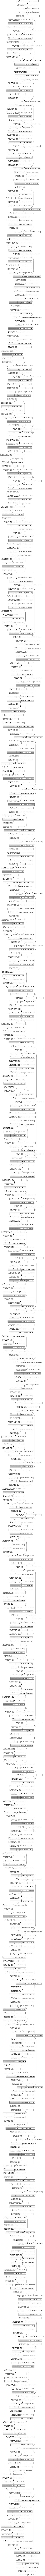

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False, show_layer_activations=True)

Защищаемся от переобучения, определяя функцию ранеего останова по параметру val_loss и чекпоинт для сохранения лучшей модели по параметру val_accuracy

In [5]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_FILE,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq = 'epoch',
)

Обучаем модель

Epoch 1/12
1363/1363 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.8566
Epoch 1: val_accuracy improved from -inf to 0.93997, saving model to model.h5
1363/1363 [==============================] - 678s 472ms/step - loss: 0.5088 - accuracy: 0.8566 - val_loss: 0.1601 - val_accuracy: 0.9400
Epoch 2/12
1363/1363 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9673
Epoch 2: val_accuracy improved from 0.93997 to 0.98198, saving model to model.h5
1363/1363 [==============================] - 608s 446ms/step - loss: 0.0979 - accuracy: 0.9673 - val_loss: 0.0562 - val_accuracy: 0.9820
Epoch 3/12
1363/1363 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9548
Epoch 3: val_accuracy did not improve from 0.98198
1363/1363 [==============================] - 548s 402ms/step - loss: 0.1376 - accuracy: 0.9548 - val_loss: 0.0887 - val_accuracy: 0.9739
Epoch 4/12
1363/1363 [==============================] - ETA: 0s - loss: 0.0990 - accu

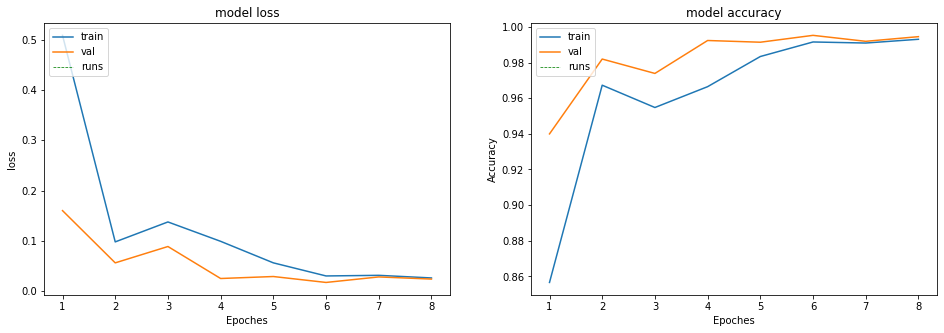

In [6]:
EPOCHES = 12

history = model.fit(
    x = train_generator,
    batch_size = BATCH_SIZE,
    validation_data = train_generator,
    epochs = EPOCHES,
    shuffle = True,
    callbacks = [early, checkpoint],
)

loss += history.history['loss']
val_loss += history.history['val_loss']
accuracy += history.history['accuracy']
val_accuracy += history.history['val_accuracy']
runs += [max(runs, default=0) + len(history.history['loss'])]

fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(121)
ax.plot(loss)
ax.plot(val_loss)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('Epoches')
ax.legend(['train', 'val', 'runs'], loc='upper left')

ax = fig.add_subplot(122)
ax.plot(accuracy)
ax.plot(val_accuracy)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoches')
ax.legend(['train', 'val', 'runs'], loc='upper left')

Восстанавливаем модель с лучшим показателем val_accuracy

In [7]:
model.load_weights(MODEL_FILE)

Построение матрицы ошибок (Confusion Matrix)

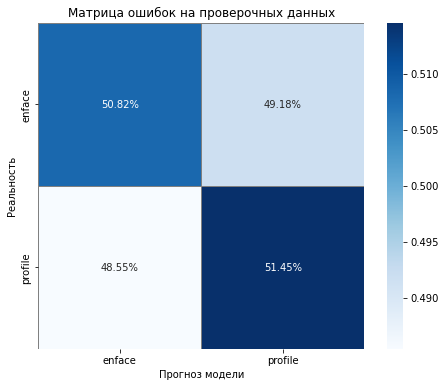

In [8]:
y_pred = model.predict(val_generator)
y_val = val_generator.classes
class_names = list(val_generator.class_indices.keys())

cm = sklearn.metrics.confusion_matrix(
    y_true = [class_names[i] for i in y_val],
    y_pred = [class_names[numpy.argmax(i)] for i in y_pred],
    labels = class_names,
)

cmn = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

plt.figure(figsize=(8,6))
ax = seaborn.heatmap(cmn, annot=True, fmt='.2%', xticklabels=class_names, yticklabels=class_names, cmap='Blues', square=True, linewidths=0.5, linecolor='gray')
ax.set_title('Матрица ошибок на проверочных данных');
ax.set_xlabel('Прогноз модели')
ax.set_ylabel('Реальность');
plt.show()

In [9]:
#for i in gen:
#    idx = (gen.batch_index - 1) * gen.batch_size
#    print(gen.filenames[idx : idx + gen.batch_size])

In [12]:
test_generator_args = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'seed': 0,
    #'classes': ['enface', 'profile'],
    'class_mode': None,
    'directory': TEST_DATASET_DIR,
    'target_size': IMG_SIZE,
    'color_mode': 'rgb',
    'interpolation': 'bicubic',
}

test_generator = datagen.flow_from_directory(**test_generator_args)

Found 11514 images belonging to 1 classes.


In [14]:
y_test = model.predict(test_generator)

In [24]:
y_test

array([[9.9951363e-01, 4.8635414e-04],
       [9.9999952e-01, 4.4668516e-07],
       [9.9991918e-01, 8.0838108e-05],
       ...,
       [9.9998820e-01, 1.1854756e-05],
       [9.9989748e-01, 1.0252897e-04],
       [1.0502988e-03, 9.9894971e-01]], dtype=float32)

In [20]:
test_df = pandas.DataFrame({
    'filename': [str.replace('test/ ', '') for str in test_generator.filenames],
    'label': [numpy.argmax(i) for i in y_test],
    'class': [class_names[numpy.argmax(i)] for i in y_test],
})

test_df

,filename,label,class
0,1.png,0,enface
1,10.png,0,enface
2,100.png,0,enface
3,1000.png,1,profile
4,10000.png,1,profile
...,...,...,...
11509,9995.png,1,profile
11510,9996.png,1,profile
11511,9997.png,0,enface
11512,9998.png,0,enface


In [21]:
test_df.to_csv('submission.csv', sep=',', index=False, columns=['filename', 'label'])